In [1]:
import numpy as np
import torch

from models import MPS, ComplexTensor
from utils import build_ghz_plus
from qtools import pauli_exp
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from utils import MeasurementDataset,do_local_sgd_training, evaluate, do_validation
from utils import estimate_fidelity
import matplotlib.pyplot as plt
import datetime
from utils import make_linear_schedule, make_exp_schedule

Loaded libmkl_rt.so for dgesvd


Pick system size, dimensionality of local hilbert space, and initial bond dim

In [2]:
L=4
local_dim=2
bond_dim=2

In [3]:
# dev = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
dev = torch.device("cpu")

Initialize the MPS model

In [4]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [5]:
psi.to(device=dev)

The ground truth state (a ghz state with no phase)

In [6]:
ghz_plus = build_ghz_plus(L)
ghz_plus.to(device=dev)

Samples_tr: lists indices of the observed basis states at each measurement. 0 = spin up, 1 = spin down

settings: array of corresponding angles

In [7]:
# fname_settings = "test_datasets/settings_ghz_plus_random_basis_L=%d.npy"%L
# fname_samples = "test_datasets/samples_ghz_plus_random_basis_L=%d.npy"%L
fname_settings = "datasets/mps_sampled/ghz_plus_L=%d_angles.npy"%L
fname_samples = "datasets/mps_sampled/ghz_plus_L=%d_outcomes.npy"%L
Nsamp=100000
samples = np.load(fname_samples)[:Nsamp]
samples_tr = torch.tensor((1-samples)/2).to(dtype=torch.long,device=dev)
settings = np.load(fname_settings)[:Nsamp]

In [8]:
theta = torch.tensor(settings[...,0],dtype=torch.float32,device=dev)
phi = torch.tensor(settings[...,1],dtype=torch.float32,device=dev)

Holds the unitaries corresponding to each angle

In [9]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

In [10]:
Ntrial = 20
N_per_trial=10

In [11]:
N_to_try = 10**np.linspace(2, 5,Ntrial)

In [13]:
fall = np.empty((Ntrial, N_per_trial))


In [14]:
for i in range(Ntrial):
    Nsamp = int(N_to_try[i])
    for j in range(N_per_trial):
        perm = torch.randperm(samples_tr.shape[0])
        s = samples_tr[perm, ...][:Nsamp]
        rot = U[perm, ...][:Nsamp]
        fall[i,j] = estimate_fidelity(ghz_plus, s, rot)

In [15]:
fmean = np.mean(fall, axis=1)
ferr = np.std(fall, axis=1)/np.sqrt(N_per_trial)

In [16]:
import matplotlib.pyplot as plt

Text(0,0.5,'f')

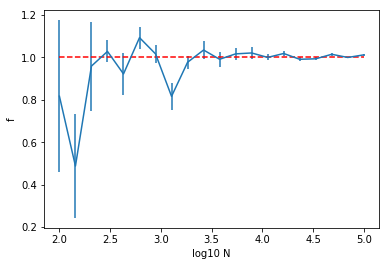

In [18]:
plt.errorbar(np.log(N_to_try)/np.log(10), fmean, yerr=ferr)
plt.plot(np.log(N_to_try)/np.log(10), np.ones_like(N_to_try), 'r--')
plt.xlabel("log10 N")
plt.ylabel("f")